In [1]:
import numpy as np
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,hamming_loss,accuracy_score

In [2]:
# wandb.login(key="a3ab9e880247c3575c105c3a5abb88ebc2eba87a")

### Dataset analysis using mean,standard deviation,min and max values for all attributes

In [3]:
data=pd.read_csv('WineQT.csv')
summary_stats = pd.DataFrame({
    "Mean": data.mean(),
    "Std": data.std(),
    "Min": data.min(),
    "Max": data.max()
})
print(summary_stats)

                            Mean         Std      Min         Max
fixed acidity           8.311111    1.747595  4.60000    15.90000
volatile acidity        0.531339    0.179633  0.12000     1.58000
citric acid             0.268364    0.196686  0.00000     1.00000
residual sugar          2.532152    1.355917  0.90000    15.50000
chlorides               0.086933    0.047267  0.01200     0.61100
free sulfur dioxide    15.615486   10.250486  1.00000    68.00000
total sulfur dioxide   45.914698   32.782130  6.00000   289.00000
density                 0.996730    0.001925  0.99007     1.00369
pH                      3.311015    0.156664  2.74000     4.01000
sulphates               0.657708    0.170399  0.33000     2.00000
alcohol                10.442111    1.082196  8.40000    14.90000
quality                 5.657043    0.805824  3.00000     8.00000
Id                    804.969379  463.997116  0.00000  1597.00000


### Graph to show distribution of the various labels across the entire dataset

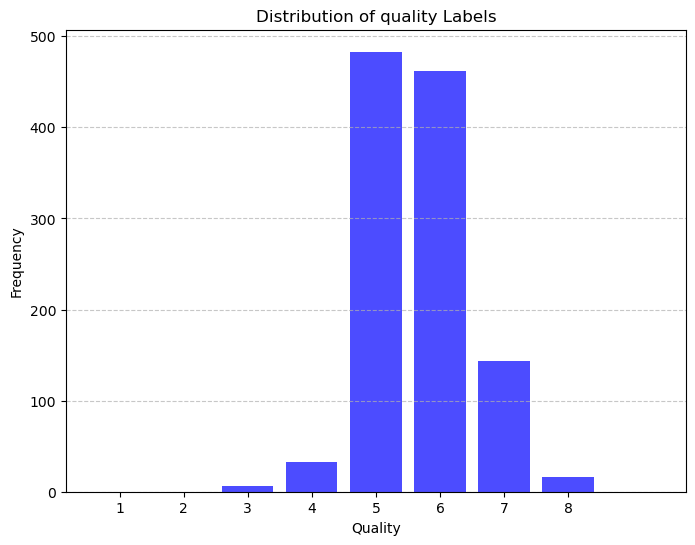

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(data['quality'], bins=range(1, 11), align="left", rwidth=0.8, color='blue', alpha=0.7)
plt.xlabel('Quality')
plt.ylabel("Frequency")
plt.title(f"Distribution of {'quality'} Labels")
plt.xticks(range(1, 9))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Splitting data into train, test and validation sets

In [5]:
X=data.loc[:,~data.columns.isin(['quality','Id'])]
y=data['quality'].values
temp=np.zeros((y.shape[0],6), dtype=int)
temp[np.arange(y.shape[0]), y - 3] = 1
y=temp
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

### Standardizing and Normalising Data

In [6]:
scalar=StandardScaler()
scalar.fit(x_train)
x_train=scalar.transform(x_train)
x_val=scalar.transform(x_val)
x_test=scalar.transform(x_test)
minmax_scalar=MinMaxScaler()
minmax_scalar.fit(x_train)
x_train=minmax_scalar.transform(x_train)
x_val=minmax_scalar.transform(x_val)
x_test=minmax_scalar.transform(x_test)

In [7]:
class MultinomialLogisticRegression:
    def __init__(self,learning_rate,num_iterations):
        self.learning_rate=learning_rate
        self.num_iterations=num_iterations
        self.weights=None
    def set_learning_rate(self,lr):
        self.learning_rate=lr
    def set_num_iterations(self,n):
        self.num_iterations=n
    def softmax(self,z):
        exp_z=np.exp(z)
        return exp_z/np.sum(exp_z,axis=1,keepdims=True)
    def gradient_descent(self,X,y):
        scores = X@self.weights.T
        probabilities = self.softmax(scores)
        grad_weights = (probabilities-y).T@X
        self.weights -= self.learning_rate * grad_weights
    def fit(self, X, y, x_val, y_val):
        # nm=f"lr: {self.learning_rate}, epochs: {self.num_iterations}"
        # wandb.init(
        #     project="Multinomial_Logistic_Regression",
        #     config={
        #         "Learning Rate":self.learning_rate,
        #         "Epochs":self.num_iterations
        #     },
        #     name=nm
        # )
        x_train_orig=X
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        n_features = X.shape[1]
        n_classes = y.shape[1]
        self.num_classes=n_classes
        self.weights = np.zeros((n_classes, n_features))
        lv=[]
        itr=[]
        temp=0
        for i in range(self.num_iterations):
            itr.append(i)
            scores = X@self.weights.T
            probabilities = self.softmax(scores)
            log_probs=np.log(probabilities)
            loss=-np.sum(y*log_probs)
            # wandb.log({"Loss": loss})
            temp=loss
            lv.append(loss)
            self.gradient_descent(X,y)
            if i>0 and i%1000==0:
                pred=self.predict(x_val)
                # wandb.log({'Validation Accuracy': accuracy_score(y_val,pred)})
                report=classification_report(y_val,pred,zero_division=1)
                print("For Validation Set :-")
                print(f"Iteration Number : {i+1}, Loss : {loss}, Report :- ")
                print(report)
                pred=self.predict(x_train_orig)
                # wandb.log({'Train Accuracy': accuracy_score(y,pred)})
                print("For Train Set :-")
                print(f"Iteration Number : {i+1}, Loss : {loss}, Accuracy (Using hamming loss) : {1-hamming_loss(y,pred)}")
        self.final_loss=temp
        plt.plot(itr,lv)
        plt.show()
    def predict(self, X):
        if self.weights is None:
            print("Error! Predict called before fit!!")
            return
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        scores = X@self.weights.T
        probs = self.softmax(scores)
        max_indices = np.argmax(probs, axis=1).reshape(-1, 1)
        new_matrix = np.zeros((max_indices.shape[0], 6), dtype=int)
        rows, cols = np.arange(max_indices.shape[0]), max_indices.flatten()
        new_matrix[rows, cols] = 1
        return new_matrix

For Validation Set :-
Iteration Number : 1001, Loss : 638.4627194901436, Report :- 
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       1.00      0.00      0.00         5
           2       0.64      0.81      0.71        93
           3       0.60      0.61      0.60        97
           4       0.58      0.24      0.34        29
           5       1.00      0.00      0.00         2

   micro avg       0.62      0.62      0.62       229
   macro avg       0.80      0.28      0.28       229
weighted avg       0.63      0.62      0.59       229
 samples avg       0.62      0.62      1.00       229

For Train Set :-
Iteration Number : 1001, Loss : 638.4627194901436, Accuracy (Using hamming loss) : 0.8720194647201946
For Validation Set :-
Iteration Number : 2001, Loss : 625.2169156418055, Report :- 
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
       

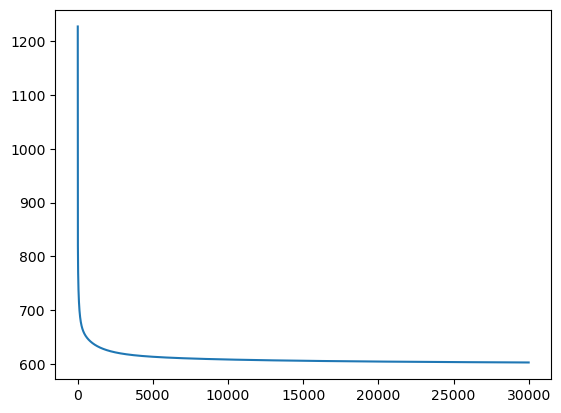

In [8]:
cl=MultinomialLogisticRegression(0.001,30000)
cl.fit(x_train,y_train,x_val,y_val)

In [9]:
print(classification_report(y_test,cl.predict(x_test), zero_division=1))
print(f"Final Loss : {cl.final_loss}")
# wandb.log({'Test Accuracy': accuracy_score(y_test,cl.predict(x_test))})
print(accuracy_score(y_test,cl.predict(x_test)))

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.00      0.00      1.00         9
           2       0.62      0.70      0.66        97
           3       0.51      0.56      0.54        93
           4       0.53      0.35      0.42        26
           5       1.00      0.00      0.00         4

   micro avg       0.56      0.56      0.56       229
   macro avg       0.44      0.43      0.44       229
weighted avg       0.55      0.56      0.58       229
 samples avg       0.56      0.56      1.00       229

Final Loss : 602.912069223275
0.5633187772925764


In [10]:
# learning_rates = [0.001,0.01,0.1]
# epochs_list = [2000, 5000, 10000]
# for lr in learning_rates:
#   for epochs in epochs_list:
#     model = MultinomialLogisticRegression(lr,epochs)
#     model.fit(x_train,y_train,x_val,y_val)
#     result = model.predict(x_test)
#     wandb.log({'Test Accuracy': accuracy_score(y_test,result)})
# wandb.finish()